In [19]:
%matplotlib inline
from keras import layers
from keras import models
from keras import losses
from keras import optimizers
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt

### Dados

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype('float32') / 255
train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [3]:
X_train = train_images[:6000, :, :]
X_train_labels = train_labels[:6000, :]

X_valid = train_images[6000:7000, :, :]
X_valid_labels= train_labels[6000:7000, :]

X_test = test_images[:1000, :, :]
X_test_labels = test_labels[:1000, :]

In [4]:
print(X_train.shape)

(6000, 28, 28, 1)


In [5]:
print(X_train_labels.shape)

(6000, 10)


In [6]:
def plotFigureHistory(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

### Questão 01

In [7]:
def calculateModel(funcl,opt):
    model = models.Sequential()
    model.add(layers.Conv2D(filters= 32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters = 64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters = 64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(units= 64, activation='relu'))
    model.add(layers.Dense(units=10, activation='softmax'))
    
    model.compile(optimizer=opt, loss=funcl, metrics=['accuracy'])
    history = model.fit(X_train, X_train_labels, epochs=10, batch_size=64, 
                          validation_data=(X_valid, X_valid_labels))
    
    model_loss, model_acc = model.evaluate(X_test, X_test_labels)
    print('Loss: {} | Accuracy: {}'.format(model_loss, model_acc))
    
    plotFigureHistory(history)

#### Loss: mean_squared_error | Optimizer: SGD

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 5s 777us/step - loss: 0.0899 - acc: 0.1120 - val_loss: 0.0899 - val_acc: 0.1170
Epoch 2/10
6000/6000 [==============================] - 3s 482us/step - loss: 0.0899 - acc: 0.1173 - val_loss: 0.0898 - val_acc: 0.1230
Epoch 3/10
6000/6000 [==============================] - 3s 461us/step - loss: 0.0898 - acc: 0.1247 - val_loss: 0.0898 - val_acc: 0.1300
Epoch 4/10
6000/6000 [==============================] - 3s 467us/step - loss: 0.0898 - acc: 0.1347 - val_loss: 0.0897 - val_acc: 0.1380
Epoch 5/10
6000/6000 [==============================] - 3s 464us/step - loss: 0.0897 - acc: 0.1438 - val_loss: 0.0897 - val_acc: 0.1470
Epoch 6/10
6000/6000 [==============================] - 3s 537us/step - loss: 0.0897 - acc: 0.1518 - val_loss: 0.0896 - val_acc: 0.1580
Epoch 7/10
6000/6000 [==============================] - 3s 552us/step - loss: 0.0896 - acc: 0.1607 - val_loss: 0.0896 - val_acc: 0.1640


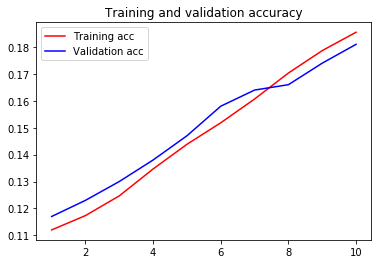

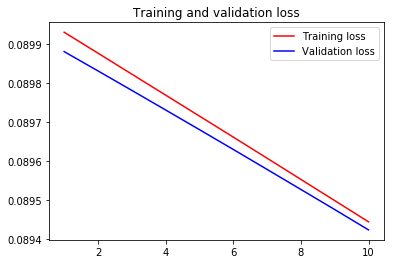

In [8]:
calculateModel(funcl=losses.mean_squared_error,opt=optimizers.SGD())

#### Loss: mean_squared_error | Optimizer: Adamax

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 654us/step - loss: 0.0376 - acc: 0.7302 - val_loss: 0.0178 - val_acc: 0.8770
Epoch 2/10
6000/6000 [==============================] - 3s 530us/step - loss: 0.0136 - acc: 0.9125 - val_loss: 0.0097 - val_acc: 0.9320
Epoch 3/10
6000/6000 [==============================] - 3s 474us/step - loss: 0.0088 - acc: 0.9433 - val_loss: 0.0064 - val_acc: 0.9610
Epoch 4/10
6000/6000 [==============================] - 3s 512us/step - loss: 0.0066 - acc: 0.9582 - val_loss: 0.0063 - val_acc: 0.9600
Epoch 5/10
6000/6000 [==============================] - 3s 502us/step - loss: 0.0053 - acc: 0.9662 - val_loss: 0.0054 - val_acc: 0.9700
Epoch 6/10
6000/6000 [==============================] - 3s 534us/step - loss: 0.0046 - acc: 0.9717 - val_loss: 0.0060 - val_acc: 0.9620
Epoch 7/10
6000/6000 [==============================] - 3s 471us/step - loss: 0.0040 - acc: 0.9752 - val_loss: 0.0047 - val_acc: 0.9730


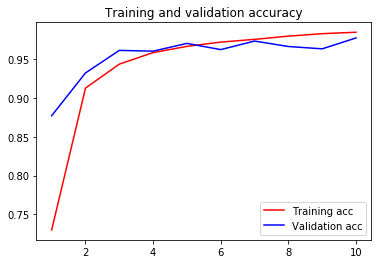

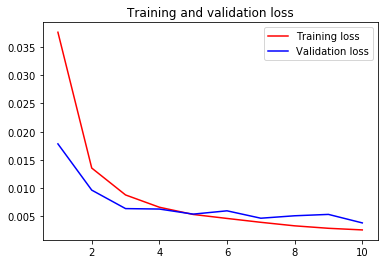

In [9]:
calculateModel(funcl=losses.mean_squared_error,opt=optimizers.Adamax())

#### Loss: mean_squared_error | Optimizer: Nadam

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 609us/step - loss: 0.1594 - acc: 0.1608 - val_loss: 0.1774 - val_acc: 0.1130
Epoch 2/10
6000/6000 [==============================] - 3s 513us/step - loss: 0.1776 - acc: 0.1118 - val_loss: 0.1774 - val_acc: 0.1130
Epoch 3/10
6000/6000 [==============================] - 3s 520us/step - loss: 0.1776 - acc: 0.1118 - val_loss: 0.1774 - val_acc: 0.1130
Epoch 4/10
6000/6000 [==============================] - 3s 503us/step - loss: 0.1776 - acc: 0.1118 - val_loss: 0.1774 - val_acc: 0.1130
Epoch 5/10
6000/6000 [==============================] - 3s 537us/step - loss: 0.1776 - acc: 0.1118 - val_loss: 0.1774 - val_acc: 0.1130
Epoch 6/10
6000/6000 [==============================] - 3s 495us/step - loss: 0.1776 - acc: 0.1118 - val_loss: 0.1774 - val_acc: 0.1130
Epoch 7/10
6000/6000 [==============================] - 3s 549us/step - loss: 0.1776 - acc: 0.1118 - val_loss: 0.1774 - val_acc: 0.1130


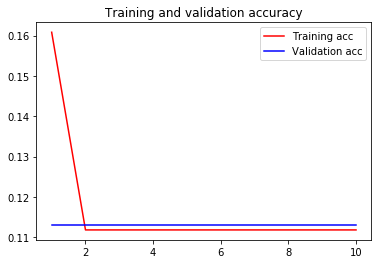

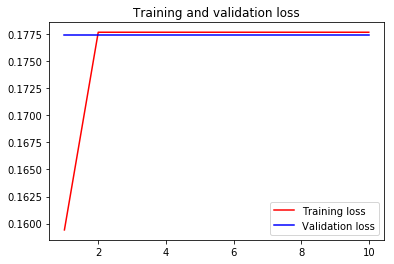

In [10]:
calculateModel(funcl=losses.mean_squared_error,opt=optimizers.Nadam())

#### Loss: poisson | Optimizer: SGD

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 590us/step - loss: 0.3312 - acc: 0.1225 - val_loss: 0.3305 - val_acc: 0.1390
Epoch 2/10
6000/6000 [==============================] - 3s 577us/step - loss: 0.3305 - acc: 0.1312 - val_loss: 0.3299 - val_acc: 0.1410
Epoch 3/10
6000/6000 [==============================] - 3s 488us/step - loss: 0.3299 - acc: 0.1408 - val_loss: 0.3293 - val_acc: 0.1500
Epoch 4/10
6000/6000 [==============================] - 3s 548us/step - loss: 0.3293 - acc: 0.1467 - val_loss: 0.3288 - val_acc: 0.1620
Epoch 5/10
6000/6000 [==============================] - 3s 538us/step - loss: 0.3287 - acc: 0.1547 - val_loss: 0.3282 - val_acc: 0.1690
Epoch 6/10
6000/6000 [==============================] - 3s 527us/step - loss: 0.3281 - acc: 0.1623 - val_loss: 0.3276 - val_acc: 0.1760
Epoch 7/10
6000/6000 [==============================] - 3s 503us/step - loss: 0.3275 - acc: 0.1687 - val_loss: 0.3270 - val_acc: 0.1800


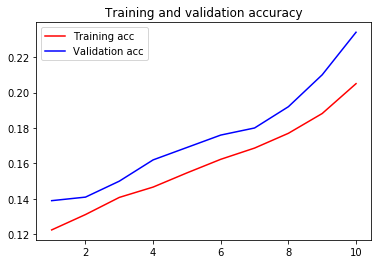

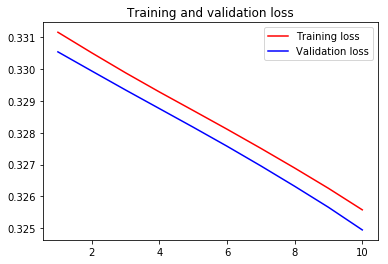

In [11]:
calculateModel(funcl=losses.poisson,opt=optimizers.SGD())

#### Loss: poisson | Optimizer: Adamax

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 628us/step - loss: 0.1833 - acc: 0.7548 - val_loss: 0.1304 - val_acc: 0.9070
Epoch 2/10
6000/6000 [==============================] - 3s 463us/step - loss: 0.1255 - acc: 0.9222 - val_loss: 0.1257 - val_acc: 0.9150
Epoch 3/10
6000/6000 [==============================] - 3s 527us/step - loss: 0.1178 - acc: 0.9453 - val_loss: 0.1148 - val_acc: 0.9550
Epoch 4/10
6000/6000 [==============================] - 3s 466us/step - loss: 0.1130 - acc: 0.9602 - val_loss: 0.1118 - val_acc: 0.9650
Epoch 5/10
6000/6000 [==============================] - 3s 518us/step - loss: 0.1111 - acc: 0.9663 - val_loss: 0.1116 - val_acc: 0.9720
Epoch 6/10
6000/6000 [==============================] - 3s 482us/step - loss: 0.1090 - acc: 0.9720 - val_loss: 0.1109 - val_acc: 0.9710
Epoch 7/10
6000/6000 [==============================] - 3s 510us/step - loss: 0.1071 - acc: 0.9780 - val_loss: 0.1097 - val_acc: 0.9730


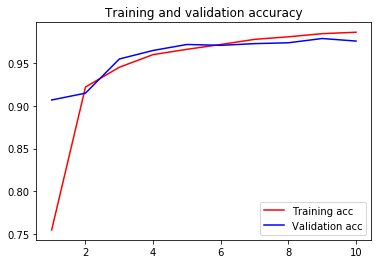

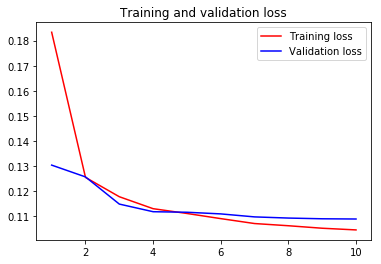

In [12]:
calculateModel(funcl=losses.poisson,opt=optimizers.Adamax())

#### Loss: poisson | Optimizer: Nadam

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 635us/step - loss: 0.1663 - acc: 0.7883 - val_loss: 0.1202 - val_acc: 0.9350
Epoch 2/10
6000/6000 [==============================] - 3s 542us/step - loss: 0.1155 - acc: 0.9525 - val_loss: 0.1145 - val_acc: 0.9570
Epoch 3/10
6000/6000 [==============================] - 3s 564us/step - loss: 0.1089 - acc: 0.9753 - val_loss: 0.1092 - val_acc: 0.9770
Epoch 4/10
6000/6000 [==============================] - 3s 536us/step - loss: 0.1061 - acc: 0.9805 - val_loss: 0.1079 - val_acc: 0.9750
Epoch 5/10
6000/6000 [==============================] - 3s 551us/step - loss: 0.1040 - acc: 0.9877 - val_loss: 0.1202 - val_acc: 0.9400
Epoch 6/10
6000/6000 [==============================] - 3s 498us/step - loss: 0.1039 - acc: 0.9862 - val_loss: 0.1071 - val_acc: 0.9830
Epoch 7/10
6000/6000 [==============================] - 3s 557us/step - loss: 0.1020 - acc: 0.9942 - val_loss: 0.1079 - val_acc: 0.9800


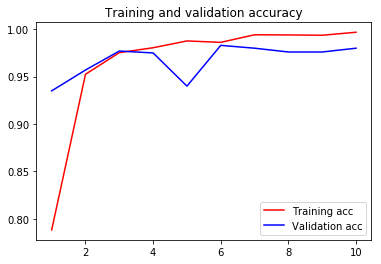

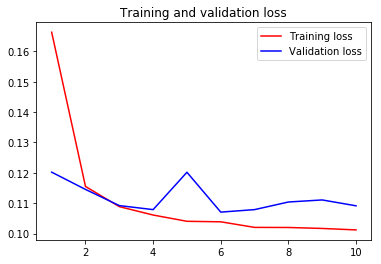

In [13]:
calculateModel(funcl=losses.poisson,opt=optimizers.Nadam())

#### Loss: categorical_crossentropy | Optimizer: SGD

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 685us/step - loss: 2.2715 - acc: 0.1558 - val_loss: 2.2301 - val_acc: 0.3230
Epoch 2/10
6000/6000 [==============================] - 3s 557us/step - loss: 2.1366 - acc: 0.4663 - val_loss: 1.9541 - val_acc: 0.5640
Epoch 3/10
6000/6000 [==============================] - 3s 486us/step - loss: 1.4497 - acc: 0.6605 - val_loss: 0.9282 - val_acc: 0.7140
Epoch 4/10
6000/6000 [==============================] - 3s 552us/step - loss: 0.7534 - acc: 0.7728 - val_loss: 0.5934 - val_acc: 0.8110
Epoch 5/10
6000/6000 [==============================] - 3s 521us/step - loss: 0.5690 - acc: 0.8203 - val_loss: 0.4722 - val_acc: 0.8470
Epoch 6/10
6000/6000 [==============================] - 3s 537us/step - loss: 0.4513 - acc: 0.8653 - val_loss: 0.4185 - val_acc: 0.8640
Epoch 7/10
6000/6000 [==============================] - 3s 544us/step - loss: 0.3811 - acc: 0.8860 - val_loss: 0.4242 - val_acc: 0.8520


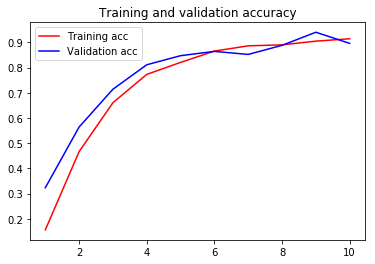

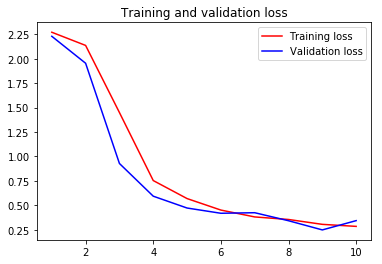

In [14]:
calculateModel(funcl=losses.categorical_crossentropy,opt=optimizers.SGD())

#### Loss: categorical_crossentropy | Optimizer: Adamax

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 677us/step - loss: 0.7953 - acc: 0.7557 - val_loss: 0.2820 - val_acc: 0.9090
Epoch 2/10
6000/6000 [==============================] - 3s 507us/step - loss: 0.2357 - acc: 0.9312 - val_loss: 0.1796 - val_acc: 0.9560
Epoch 3/10
6000/6000 [==============================] - 3s 533us/step - loss: 0.1710 - acc: 0.9498 - val_loss: 0.1610 - val_acc: 0.9560
Epoch 4/10
6000/6000 [==============================] - 3s 526us/step - loss: 0.1318 - acc: 0.9607 - val_loss: 0.1540 - val_acc: 0.9550
Epoch 5/10
6000/6000 [==============================] - 3s 551us/step - loss: 0.1074 - acc: 0.9690 - val_loss: 0.1236 - val_acc: 0.9670
Epoch 6/10
6000/6000 [==============================] - 3s 523us/step - loss: 0.0956 - acc: 0.9697 - val_loss: 0.1082 - val_acc: 0.9700
Epoch 7/10
6000/6000 [==============================] - 3s 576us/step - loss: 0.0695 - acc: 0.9808 - val_loss: 0.1141 - val_acc: 0.9720


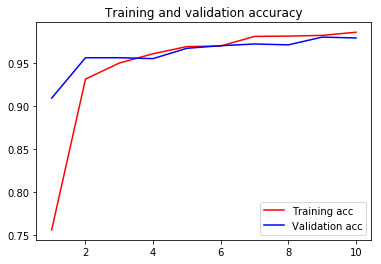

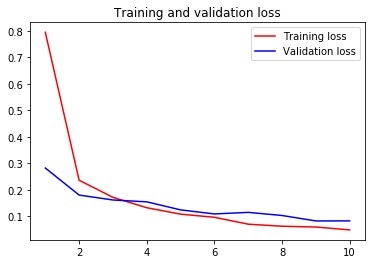

In [15]:
calculateModel(funcl=losses.categorical_crossentropy,opt=optimizers.Adamax())

#### Loss: categorical_crossentropy | Optimizer: Nadam

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 4s 677us/step - loss: 0.6545 - acc: 0.7955 - val_loss: 0.2366 - val_acc: 0.9290
Epoch 2/10
6000/6000 [==============================] - 3s 565us/step - loss: 0.1740 - acc: 0.9483 - val_loss: 0.1838 - val_acc: 0.9540
Epoch 3/10
6000/6000 [==============================] - 3s 526us/step - loss: 0.1106 - acc: 0.9643 - val_loss: 1.0888 - val_acc: 0.7740
Epoch 4/10
6000/6000 [==============================] - 3s 549us/step - loss: 0.0798 - acc: 0.9760 - val_loss: 0.1233 - val_acc: 0.9670
Epoch 5/10
6000/6000 [==============================] - 3s 568us/step - loss: 0.0524 - acc: 0.9835 - val_loss: 0.1500 - val_acc: 0.9560
Epoch 6/10
6000/6000 [==============================] - 3s 517us/step - loss: 0.0400 - acc: 0.9873 - val_loss: 0.1266 - val_acc: 0.9680
Epoch 7/10
6000/6000 [==============================] - 4s 615us/step - loss: 0.0365 - acc: 0.9882 - val_loss: 0.1163 - val_acc: 0.9740


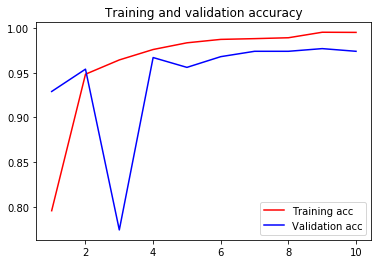

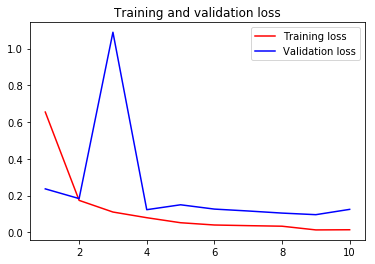

In [16]:
calculateModel(funcl=losses.categorical_crossentropy,opt=optimizers.Nadam())

### Questão 02

#### Loss: poisson | Optimizer: Nadam

In [27]:
#Model
def modelDrop(p):
    model = models.Sequential()
    model.add(layers.Conv2D(filters= 32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters = 64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters = 64, kernel_size=(3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dropout(p))
    model.add(layers.Dense(units= 64, activation='relu'))
    model.add(layers.Dense(units=10, activation='softmax'))
    model.compile(optimizer=optimizers.Nadam(), loss=losses.poisson, metrics=['accuracy'])
    
    train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

    history = model.fit_generator(datagen.flow(X_train, X_train_labels, batch_size=20), 
                                  epochs=10, validation_data=(X_valid, X_valid_labels))
    
    model_loss, model_acc = model.evaluate(X_test, X_test_labels)
    print('Loss: {} | Accuracy: {}'.format(model_loss, model_acc))
    
    plotFigureHistory(history)

P: 0.3
Epoch 1/10
300/300 [==============================] - 7s 22ms/step - loss: 0.2928 - acc: 0.3085 - val_loss: 0.1904 - val_acc: 0.7190
Epoch 2/10
300/300 [==============================] - 6s 19ms/step - loss: 0.2240 - acc: 0.5753 - val_loss: 0.1476 - val_acc: 0.8390
Epoch 3/10
300/300 [==============================] - 6s 19ms/step - loss: 0.1943 - acc: 0.6733 - val_loss: 0.1402 - val_acc: 0.8800
Epoch 4/10
300/300 [==============================] - 6s 19ms/step - loss: 0.1818 - acc: 0.7248 - val_loss: 0.1378 - val_acc: 0.8840
Epoch 5/10
300/300 [==============================] - 6s 20ms/step - loss: 0.1710 - acc: 0.7623 - val_loss: 0.1351 - val_acc: 0.8880
Epoch 6/10
300/300 [==============================] - 6s 21ms/step - loss: 0.1647 - acc: 0.7875 - val_loss: 0.1264 - val_acc: 0.9090
Epoch 7/10
300/300 [==============================] - 6s 21ms/step - loss: 0.1596 - acc: 0.8037 - val_loss: 0.1248 - val_acc: 0.9260
Epoch 8/10
300/300 [==============================] - 6s 21ms/

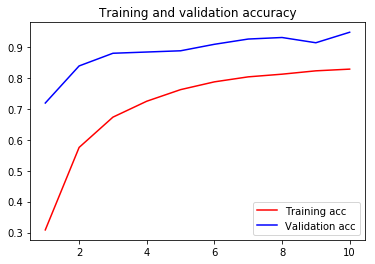

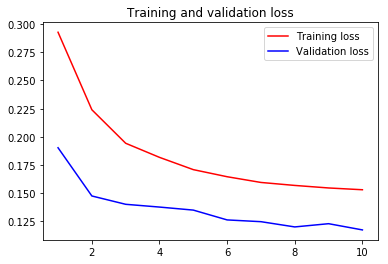

P: 0.4
Epoch 1/10
300/300 [==============================] - 7s 23ms/step - loss: 0.2930 - acc: 0.2918 - val_loss: 0.2201 - val_acc: 0.5700
Epoch 2/10
300/300 [==============================] - 6s 21ms/step - loss: 0.2349 - acc: 0.5280 - val_loss: 0.1763 - val_acc: 0.7150
Epoch 3/10
300/300 [==============================] - 6s 20ms/step - loss: 0.2057 - acc: 0.6395 - val_loss: 0.1460 - val_acc: 0.8440
Epoch 4/10
300/300 [==============================] - 7s 23ms/step - loss: 0.1888 - acc: 0.7025 - val_loss: 0.1396 - val_acc: 0.8760
Epoch 5/10
300/300 [==============================] - 6s 21ms/step - loss: 0.1793 - acc: 0.7335 - val_loss: 0.1368 - val_acc: 0.8750
Epoch 6/10
300/300 [==============================] - 6s 21ms/step - loss: 0.1692 - acc: 0.7710 - val_loss: 0.1327 - val_acc: 0.8820
Epoch 7/10
300/300 [==============================] - 7s 22ms/step - loss: 0.1671 - acc: 0.7770 - val_loss: 0.1348 - val_acc: 0.8850
Epoch 8/10
300/300 [==============================] - 7s 22ms/

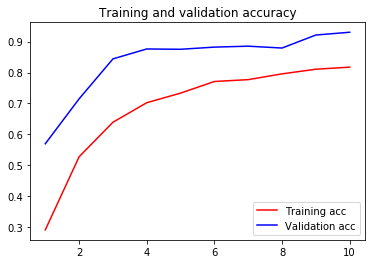

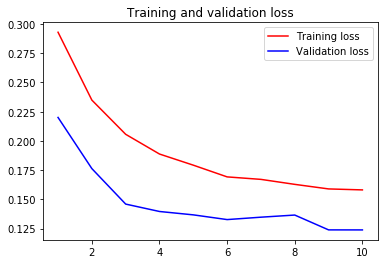

P: 0.5
Epoch 1/10
300/300 [==============================] - 8s 28ms/step - loss: 0.3001 - acc: 0.2653 - val_loss: 0.2373 - val_acc: 0.4490
Epoch 2/10
300/300 [==============================] - 6s 21ms/step - loss: 0.2383 - acc: 0.5172 - val_loss: 0.1643 - val_acc: 0.8050
Epoch 3/10
300/300 [==============================] - 6s 21ms/step - loss: 0.2120 - acc: 0.6157 - val_loss: 0.1722 - val_acc: 0.7670
Epoch 4/10
300/300 [==============================] - 6s 22ms/step - loss: 0.1955 - acc: 0.6728 - val_loss: 0.1649 - val_acc: 0.7790
Epoch 5/10
300/300 [==============================] - 7s 24ms/step - loss: 0.1859 - acc: 0.7155 - val_loss: 0.1335 - val_acc: 0.9080
Epoch 6/10
300/300 [==============================] - 7s 23ms/step - loss: 0.1743 - acc: 0.7510 - val_loss: 0.1391 - val_acc: 0.8820
Epoch 7/10
300/300 [==============================] - 7s 24ms/step - loss: 0.1703 - acc: 0.7690 - val_loss: 0.1287 - val_acc: 0.9070
Epoch 8/10
300/300 [==============================] - 7s 23ms/

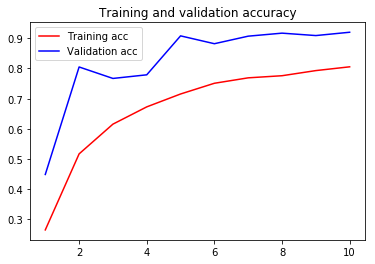

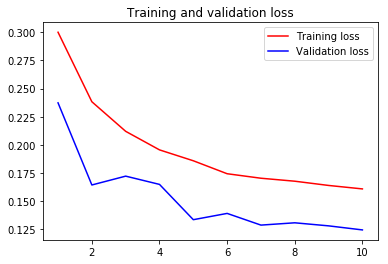

In [28]:
p = [0.3,0.4,0.5]

for i in p:
    print('P: {}'.format(i))
    modelDrop(i)